In [1]:
import sys
sys.path.append("..")

from tqdm import tqdm
import random
import numpy as np
from environments.grid_world import GridWorld

# 1. Create Grid-world environment

observation_space:  Discrete(16)
action_space:  Discrete(4) [left, down, right ,up]


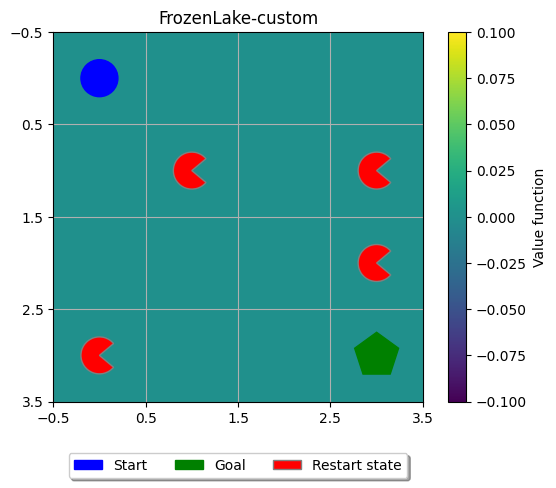

In [33]:
# specify world parameters
num_cols = 4
num_rows = 4
obstructions = None
bad_states = None
restart_states = np.array([[1,1],[1,3],[2,3],[3,0]])
start_state = np.array([[0,0]])
goal_states = np.array([[3,3]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-10)
gw.add_transition_probability(p_good_transition=1.0, bias=0)
gw.add_discount(discount=1)
env = gw.create_gridworld()

# plot the environment
print('observation_space: ', env.observation_space)
print('action_space: ', env.action_space, '[left, down, right ,up]')
env.render(title="FrozenLake-custom")

In [34]:
# transition function (no stochasticity)
# action: [left, down, right, up]
env.P[1]

{0: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 1: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 3: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [35]:
# imidiate reward at each state
env.R[15]

array([10.])

In [36]:
# test environment step
env.reset()
action = env.action_space.sample()
new_state, reward, done, info = env.step(action)
(new_state, reward, done, info)

(0,
 array([-1.]),
 False,
 {'probs': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]})

# 2. MC Prediction - State-Value Function (policy: unfied random)

## 2.1 generate episode

In [37]:
def random_policy(env):
    return env.action_space.sample()
    # return np.random.choice([1, 2], p=[0.5, 0.5])  # [down, right]

def generate_episode(policy, env):
    episode = []
    state = env.reset()
    while True:
        action = policy(env)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [38]:
# sample trajectory with success episode
for i in range(100):
    episode = generate_episode(random_policy, env)
    if episode[-1][-1] > 0:
        print(episode)
        break

[(0, 2, array([-1.])), (1, 3, array([-1.])), (1, 0, array([-1.])), (0, 1, array([-1.])), (4, 0, array([-1.])), (4, 1, array([-1.])), (8, 0, array([-1.])), (8, 2, array([-1.])), (9, 2, array([-1.])), (10, 1, array([-1.])), (14, 2, array([10.]))]


## 2.2 update state-value function

### 2.2.1 update after all episode is done

In [39]:
# create trajectories of a policy interacting with the environment
n_episodes = 1000
episodes = list()
for i in range(n_episodes):
    _episode = generate_episode(random_policy, env)
    episodes.append(_episode)

In [40]:
# update Value function from all trajectories
def mc_prediction_all(env, episodes):
    V = np.zeros(env.observation_space.n)
    N = np.zeros(env.observation_space.n)
    expected_cummulative_returns = np.zeros(env.observation_space.n)

    for episode in episodes:
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([env.gamma**i for i in range(len(rewards)+1)])
        
        # calculate the expected cummulative return at each state
        for idx, state in enumerate(states):
            N[state] += 1
            _expected_cummulative_return = 0
            for i, reward in enumerate(rewards[idx:]):
                _expected_cummulative_return += reward*discounts[i]
            expected_cummulative_returns[state] += _expected_cummulative_return

    # calculate the value average of each state
    for idx, returns in enumerate(expected_cummulative_returns):
        if N[idx] > 0:
            value = returns / N[idx]
            V[idx] = value
    
    return V, N, expected_cummulative_returns

In [41]:
V, N, expected_cummulative_returns = mc_prediction_all(env, episodes)
V

array([-16.52675965, -14.58193445, -14.45185185, -14.072     ,
       -14.16292135,   0.        , -12.29050279,   0.        ,
       -12.97249509, -12.44262295, -12.37623762,   0.        ,
         0.        , -11.02409639,  -9.08510638,   0.        ])

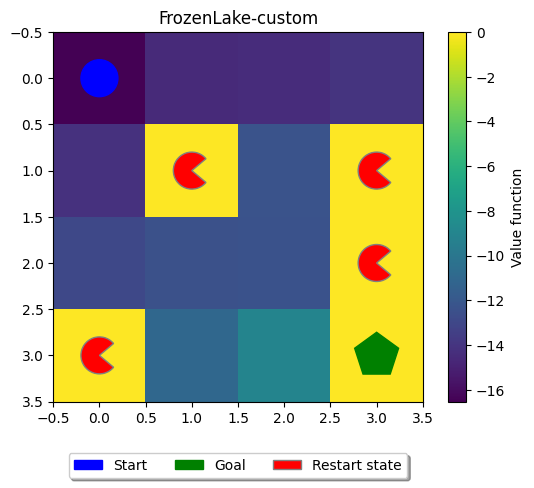

In [42]:
value_function = np.zeros((env.observation_space.n, 1))
for idx, value in enumerate(V):
    value_function[idx] = [value]

env.render(title="FrozenLake-custom", value_function=value_function)

### 2.2.2 update at each episode

In [43]:
# create trajectories of a policy interacting with the environment
n_episodes = 1000
episodes = list()
for i in range(n_episodes):
    _episode = generate_episode(random_policy, env)
    episodes.append(_episode)

In [44]:
# update Value function at the end of each episode (first-visit and every-visit)
def mc_prediction_by_episode(env, episodes, first_visit=False):
    V = np.zeros(env.observation_space.n)
    N = np.zeros(env.observation_space.n)

    for episode in episodes:
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([env.gamma**i for i in range(len(rewards)+1)])
        
        # update the sum of the returns, number of visits, and value function
        expected_cummulative_returns = np.zeros(env.observation_space.n)
        for idx, state in enumerate(states):
            if first_visit:
                if N[state] > 0:
                    continue
            N[state] += 1.0
            _expected_cummulative_return = 0
            for i, reward in enumerate(rewards[idx:]):
                _expected_cummulative_return += reward*discounts[i]
            expected_cummulative_returns[state] += _expected_cummulative_return
        
            # update value function at the end of each episode
            V[state] = V[state] + (expected_cummulative_returns[state] - V[state]) / N[state]
    
    return V, N

In [45]:
V_first_visit, N = mc_prediction_by_episode(env, episodes, first_visit=True)
V_first_visit

array([-16., -14., -12., -10., -17.,   0., -10.,   0., -17., -11., -12.,
         0.,   0., -10.,  10.,   0.])

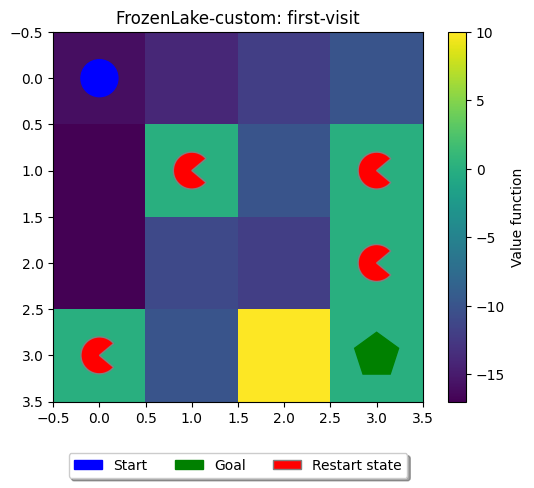

In [46]:
value_function = np.zeros((env.observation_space.n, 1))
for idx, value in enumerate(V_first_visit):
    value_function[idx] = [value]
env.render(title="FrozenLake-custom: first-visit", value_function=value_function)

In [47]:
V_every_visit, N = mc_prediction_by_episode(env, episodes, first_visit=False)
V_every_visit

array([-61.7776424 , -33.15910727, -32.09395973, -46.12162162,
       -31.61274099,   0.        , -16.30054645,   0.        ,
       -26.29953917, -20.97515528, -15.76595745,   0.        ,
         0.        , -20.48051948,  -7.57894737,   0.        ])

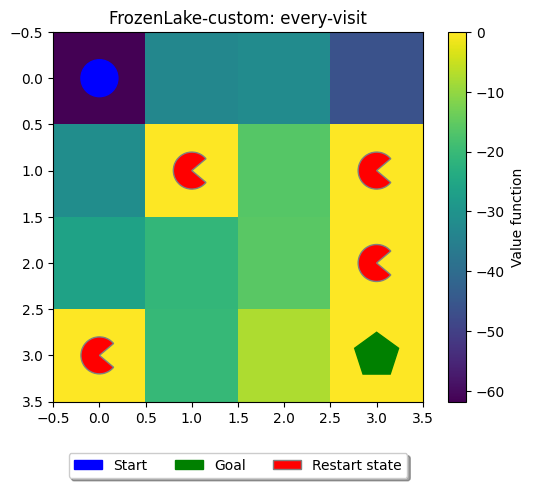

In [48]:
value_function = np.zeros((env.observation_space.n, 1))
for idx, value in enumerate(V_every_visit):
    value_function[idx] = [value]
env.render(title="FrozenLake-custom: every-visit", value_function=value_function)

# 3. MC Prediction - Action-Value Function (policy: unfied random)

## 3.1 generate episode

In [49]:
def random_policy(env):
    return env.action_space.sample()
    # return np.random.choice([1, 2], p=[0.5, 0.5])  # [down, right]

def generate_episode(policy, env):
    episode = []
    state = env.reset()
    while True:
        action = policy(env)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [50]:
# sample trajectory with success episode
for i in range(100):
    episode = generate_episode(random_policy, env)
    if episode[-1][-1] > 0:
        print(episode)
        break

## 3.2 update action-value function

### 3.2.1 update after all episode is done

In [51]:
# create trajectories of a policy interacting with the environment
n_episodes = 1000
episodes = list()
for i in range(n_episodes):
    _episode = generate_episode(random_policy, env)
    episodes.append(_episode)

In [52]:
# update Value function from all trajectories
def mc_prediction_all(env, episodes):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    N = np.zeros((env.observation_space.n, env.action_space.n))
    expected_cummulative_returns = np.zeros((env.observation_space.n, env.action_space.n))

    for episode in episodes:
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([env.gamma**i for i in range(len(rewards)+1)])
        
        # calculate the expected cummulative return at each state
        for idx, state in enumerate(states):
            N[state][actions[idx]] += 1
            _expected_cummulative_return = 0
            for i, reward in enumerate(rewards[idx:]):
                _expected_cummulative_return += reward*discounts[i]
            expected_cummulative_returns[state][actions[idx]] += _expected_cummulative_return

    # calculate the value average of each state-action pair
    for state in range(env.observation_space.n):
        for action in range(env.action_space.n):
            if N[state][action] > 0:
                Q[state][action] = expected_cummulative_returns[state][action] / N[state][action]
    
    return Q, N, expected_cummulative_returns

In [53]:
Q, N, expected_cummulative_returns = mc_prediction_all(env, episodes)
Q

array([[-17.41956242, -15.26070991, -15.80906921, -17.74545455],
       [-17.76627219, -10.        , -16.375     , -16.12671233],
       [-16.22972973, -13.18691589, -15.10791367, -16.30434783],
       [-16.546875  , -10.        , -14.10526316, -15.56578947],
       [-14.93113772, -14.02523659, -10.        , -17.48580442],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [-10.        , -11.93548387, -10.        , -15.85294118],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [-13.17730496, -10.        , -12.26923077, -14.921875  ],
       [-13.37777778,  -9.6       , -12.04651163, -10.        ],
       [-12.13333333, -11.05263158, -10.        , -12.19047619],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [-10.        ,  -7.91304348,  -5.30434783, -12.10526316],
       [-13.08333333,  -1.55      ,  10.        , -14.29411765],
       [  0.        ,   0

In [54]:
# calculate value function from uniformly random action props
V = np.zeros(env.observation_space.n)
for idx, value in enumerate(Q):
    V[idx] = np.mean(value)
V

array([-16.55869902, -15.06699613, -15.20722678, -14.05448191,
       -14.11054468,   0.        , -11.94710626,   0.        ,
       -12.59210268, -11.25607235, -11.34411028,   0.        ,
         0.        ,  -8.83066362,  -4.73186275,   0.        ])

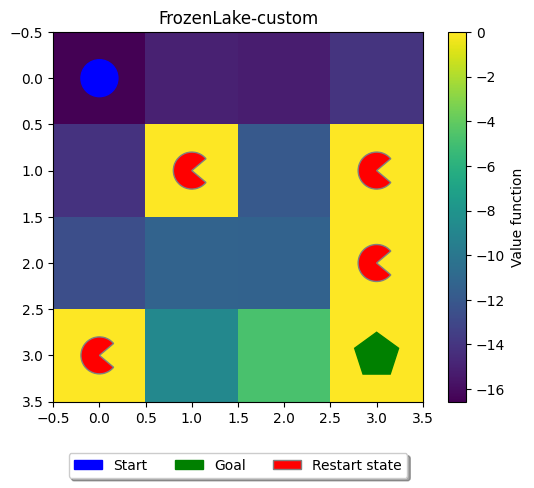

In [55]:
value_function = np.zeros((env.observation_space.n, 1))
for idx, value in enumerate(V):
    value_function[idx] = [value]

env.render(title="FrozenLake-custom", value_function=value_function)

### 3.2.2 update at each episode

In [56]:
# create trajectories of a policy interacting with the environment
n_episodes = 1000
episodes = list()
for i in range(n_episodes):
    _episode = generate_episode(random_policy, env)
    episodes.append(_episode)

In [57]:
# update Value function at the end of each episode (first-visit and every-visit)
def mc_prediction_by_episode(env, episodes, first_visit=False):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    N = np.zeros((env.observation_space.n, env.action_space.n))
    expected_cummulative_returns = np.zeros((env.observation_space.n, env.action_space.n))

    for episode in episodes:
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([env.gamma**i for i in range(len(rewards)+1)])
        
        # calculate the expected cummulative return at each state
        for idx, state in enumerate(states):
            if first_visit:
                if N[state][actions[idx]] > 0:
                    continue
            N[state][actions[idx]] += 1
            _expected_cummulative_return = 0
            for i, reward in enumerate(rewards[idx:]):
                _expected_cummulative_return += reward*discounts[i]
            expected_cummulative_returns[state][actions[idx]] += _expected_cummulative_return

    # calculate the value average of each state-action pair
    for state in range(env.observation_space.n):
        for action in range(env.action_space.n):
            if N[state][action] > 0:
                Q[state][action] = expected_cummulative_returns[state][action] / N[state][action]
    
    return Q, N

In [58]:
Q_first_visit, N = mc_prediction_by_episode(env, episodes, first_visit=True)
Q_first_visit

array([[-27., -19., -25., -26.],
       [-20., -10., -24., -11.],
       [-12., -21., -23., -24.],
       [-22., -10., -18., -17.],
       [-23., -18., -10., -16.],
       [  0.,   0.,   0.,   0.],
       [-10., -13., -10., -20.],
       [  0.,   0.,   0.,   0.],
       [-11., -10., -21., -17.],
       [-16., -14., -11., -10.],
       [-12., -19., -10., -11.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [-10., -13., -17., -11.],
       [-18., -20.,  10., -16.],
       [  0.,   0.,   0.,   0.]])

In [59]:
# calculate value function from uniformly random action props
V_first_visit = np.zeros(env.observation_space.n)
for idx, value in enumerate(Q_first_visit):
    V_first_visit[idx] = np.mean(value)
V_first_visit

array([-24.25, -16.25, -20.  , -16.75, -16.75,   0.  , -13.25,   0.  ,
       -14.75, -12.75, -13.  ,   0.  ,   0.  , -12.75, -11.  ,   0.  ])

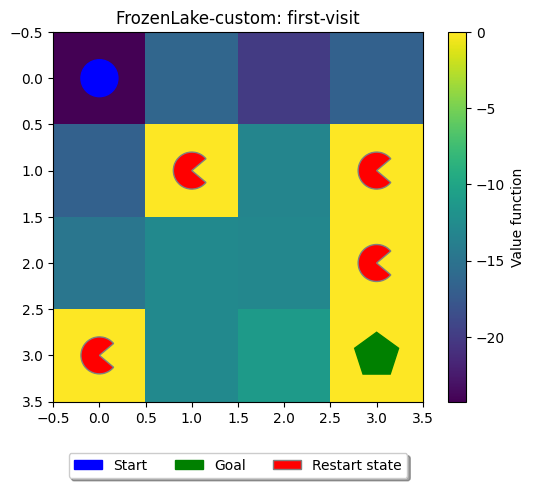

In [60]:
value_function = np.zeros((env.observation_space.n, 1))
for idx, value in enumerate(V_first_visit):
    value_function[idx] = [value]
env.render(title="FrozenLake-custom: first-visit", value_function=value_function)

In [61]:
Q_every_visit, N = mc_prediction_by_episode(env, episodes, first_visit=False)
Q_every_visit

array([[-17.24224344, -15.06177156, -15.70616687, -17.0295203 ],
       [-17.44023324, -10.        , -15.18068536, -15.66077739],
       [-15.42335766, -12.12337662, -14.68707483, -15.87288136],
       [-15.47058824, -10.        , -14.33333333, -13.72289157],
       [-14.8742515 , -14.19811321, -10.        , -16.9502924 ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [-10.        , -10.18367347, -10.        , -15.71428571],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [-14.18852459, -10.        , -12.78991597, -15.63636364],
       [-14.05128205, -10.88571429, -12.29411765, -10.        ],
       [-11.5       ,  -1.44      , -10.        , -14.625     ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [-10.        ,  -8.91666667,  -5.        , -13.93333333],
       [-10.07142857, -12.66666667,  10.        ,  -8.14285714],
       [  0.        ,   0

In [62]:
# calculate value function from uniformly random action props
V_every_visit = np.zeros(env.observation_space.n)
for idx, value in enumerate(Q_every_visit):
    V_every_visit[idx] = np.mean(value)
V_every_visit

array([-16.25992554, -14.57042399, -14.52667262, -13.38170328,
       -14.00566428,   0.        , -11.4744898 ,   0.        ,
       -13.15370105, -11.8077785 ,  -9.39125   ,   0.        ,
         0.        ,  -9.4625    ,  -5.2202381 ,   0.        ])

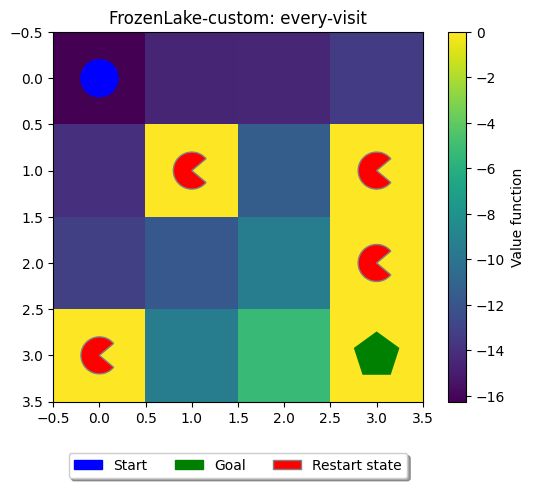

In [63]:
value_function = np.zeros((env.observation_space.n, 1))
for idx, value in enumerate(V_every_visit):
    value_function[idx] = [value]
env.render(title="FrozenLake-custom: every-visit", value_function=value_function)